In [4]:
using LinearAlgebra
using Distributions: Bernoulli
using Plots
pyplot()
using SpecialFunctions: erf


# CDF of 1D Gaussian
ϕ(μ,σ) = 0.5( 1. + (erf( μ / (σ * √(2)) )))

# Binary entropy. Epsilons for stability
h(p) = -p*log(p+eps()) - (1-p)*log(1-p + eps())

# Approximate conditional entropy term
C = √((π*log(2)/2))
H(μ,σ) = (C / √(σ + C^2))* exp(-0.5 * (μ^2 / (σ + C^2)))

# BALD objective. Approximations from Houlsby, 2011
BALD(μ,σ) = h(ϕ(μ,sqrt(σ + 1))) - H(μ,σ)
KL(p,q) = p * log(p/q) + (1-p) * log( (1-p)/(1-q))


# SE kernel for 1D inputs
function kernel(x1,x2,σ,l)
    σ * exp.(-0.5 * (x1 .- x2').^2)
end

# user preference function. Decreases away from ideal point of 5.0
p_func(x) = exp(-(5-x)^2)

# User response function
function response(x)
    p = p_func(x)
    Float64(rand(Bernoulli(p))) # Somehow crashes if not recast to float
end

# Predictions from GP
function predict(x1,y1,x2,σ,l)
    n = size(x1,1)
    Σ_11 = kernel(x1, x1, σ, l) + I(n) # Standard Gaussian observation noise. 
    Σ_22 = kernel(x2, x2, σ, l)
    Σ_12 = kernel(x1, x2, σ, l)

    # Rasmussen tricks for stability and efficiency
    chol11 = cholesky(Σ_11)
    solved = chol11.U\(chol11.L\Σ_12)

    Σ_pred= Σ_22 - solved' * Σ_12
    μ_pred = solved' * y1
    return μ_pred, Σ_pred
end


function choose_point(x1,y1,x2,σ,l)
    μ_pred,Σ_pred =predict(x1,y1,x2,σ,l) # Generate prediction
    # Compute EFE. Set up as -MI (the BALD objective) and cross entropy as KL + entropy
    # Commenting out the last entropy term recovers APD from Hafner, 2020
    -BALD(μ_pred[1],Σ_pred[1]) + KL(ϕ(μ_pred[1],sqrt(Σ_pred[1] + 1)),1-eps()) + h(ϕ(μ_pred[1],sqrt(Σ_pred[1] +1)))
end

# Bookkeeping
#temp = []
xs = []
ids = []

# Generate an initial data point to start the process
x1 = 2. .+ randn(1)
y1 = response.(x1)


1-element Array{Float64,1}:
 0.0

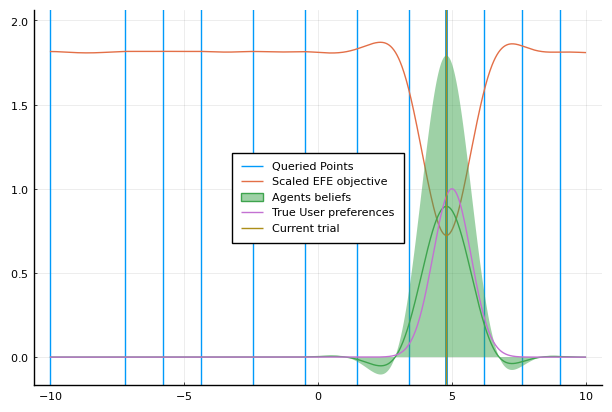

Animation("/tmp/jl_p9nQaZ", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

In [5]:
# Run an experiment
anim = @animate for t ∈ 1:20
    # Fixed kernel hyperparams
    σ = 1.
    l = 0.1

    # Grid to search over
    gridman =LinRange(-10,10,1000)
    
    # Compute objective and pick the next point
    idx = argmin([choose_point(x1,y1,x2,σ,l) for x2 in gridman])
    x2 = [gridman[idx]]

    # Below here is bookkeeping and plots
    append!(y1,response(x2[1]))
    append!(x1,x2[1])

    dude = [choose_point(x1,y1,xn,σ,l) for xn in gridman]
    estimated = [predict(x1,y1,x2,σ,l) for x2 in gridman]
    Σs = [x[1] for x in estimated]
    μs = [x[1] for x in estimated]

    vline(x1,label="Queried Points")
    plot!(gridman,dude ./ 10 ,label="Scaled EFE objective")
    plot!(gridman,μs,ribbon=Σs,label="Agents beliefs")
    plot!(gridman,p_func.(gridman),label="True User preferences")
    vline!([gridman[argmin(dude)]], label="Current trial")
end


┌ Info: Saved animation to 
│   fn = /home/mkoudahl/biaslab/repos/AIDA/agent/efe_gps/anim.gif
└ @ Plots /home/mkoudahl/.config/julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/home/mkoudahl/biaslab/repos/AIDA/agent/efe_gps/anim.gif")
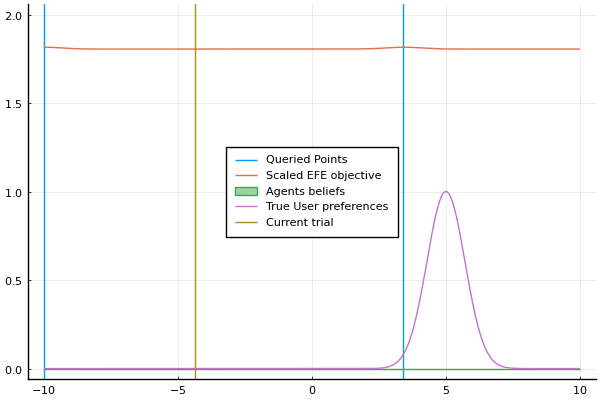

In [6]:
# Animate the experiment
gif(anim, "anim.gif", fps = 2)
